# <div align="center"> 办公工具分类 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.2

numpy 1.19.5
pandas 1.1.5
matplotlib 3.3.4
sklearn 0.24.2
torch 1.11.0.dev20211227+cu111
torchvision 0.12.0.dev20211227+cu111


In [2]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json

import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from torchvision.utils import make_grid

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
K12AI_DATASETS_ROOT = '/data/k12ai/datasets'

In [4]:
dataset = 'roffice6'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, 'imgs')

In [5]:
!ls $imgs_path

Eraser	Keyboard  Knives  Laptop  Mouse  Pencil


## 读取原始数据

In [6]:
labelnames = !ls $imgs_path
name2label = {n:i for i, n in enumerate(labelnames)}
name2label

{'Eraser': 0, 'Keyboard': 1, 'Knives': 2, 'Laptop': 3, 'Mouse': 4, 'Pencil': 5}

In [7]:
label_images = {}

def scan_images(path):
    images = []
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                images.extend(scan_images(entry.path))
            else:
                images.append(entry.path[len(imgs_path)+1:])
    return images

with os.scandir(imgs_path) as it:
    for entry in it:
        if not entry.is_dir():
            continue
        label_images[name2label[entry.name]] = scan_images(entry.path)
len(label_images), len(label_images[0]), label_images.keys()

(6, 43, dict_keys([4, 1, 0, 5, 3, 2]))

## 对比

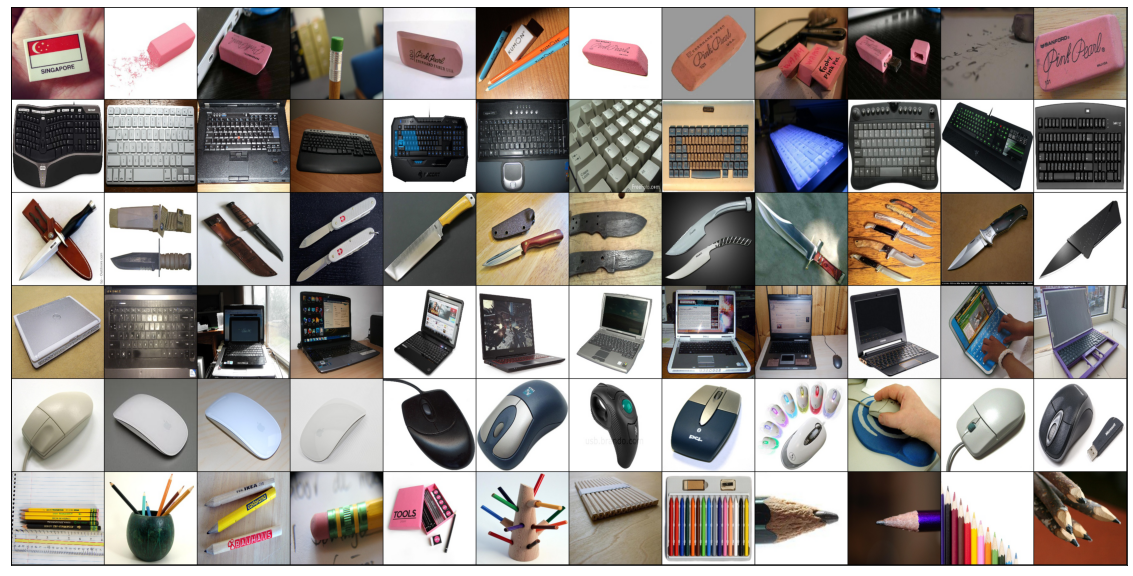

In [8]:
samples = []
sampnum = 12
for label in sorted(list(label_images.keys())):
    for img in label_images[label][:sampnum]:
        samples.append(torch.from_numpy(np.asarray(Image.open(f'{imgs_path}/{img}'))).permute(2, 0, 1))
    
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xticks([])
ax.set_yticks([])
grid_img = make_grid(samples, nrow=sampnum).permute(1, 2, 0)
ax.imshow(grid_img)

In [9]:
plt.imsave(f'{data_root}/samples_grid.jpg', grid_img.numpy())

## 切割数据集

In [10]:
# 7:2:1 split for train:valid:test dataset
all_images = []
test_images = []
valid_images = []
train_images = []
for label, files in label_images.items():
    for img in files:
        all_images.append((label, img))
        value = random.random()
        if value < 0.1: # test
            test_images.append((label, img))
        elif value < 0.3: # val
            valid_images.append((label, img))
        else: # train
            train_images.append((label, img))
test_count, val_count, train_count = len(test_images), len(valid_images), len(train_images)
test_count, val_count, train_count

(39, 86, 262)

## 生成json文件

In [11]:
def generate_json_file(images, phase):
    items = []
    for label, img in images:
        items.append({'image_path': 'imgs/' + img, 'label': int(label)})
        
    random.shuffle(items)

    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w', encoding='utf-8') as fp:
        json.dump(items, fp, ensure_ascii=False)
    return len(items)
        
# train.json
generate_json_file(train_images, 'train');

# val.json
generate_json_file(valid_images, 'val');

# test.json
generate_json_file(test_images, 'test');

# all.json
generate_json_file(all_images, 'all');

In [12]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles, resize=None)
mean, std

([0.5851, 0.5585, 0.541], [0.2335, 0.2391, 0.2447])

## 生成info.json

In [13]:
label_names = list(name2label.keys())

info = {
    'num_records': test_count + val_count + train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, ensure_ascii=False, indent=4)
    
info

{'num_records': 387,
 'num_classes': 6,
 'label_names': ['Eraser', 'Keyboard', 'Knives', 'Laptop', 'Mouse', 'Pencil'],
 'mean': [0.5851, 0.5585, 0.541],
 'std': [0.2335, 0.2391, 0.2447]}

## 数据平衡分析

In [14]:
df_train = pd.read_json(os.path.join(data_root, 'train.json'))
df_val = pd.read_json(os.path.join(data_root, 'val.json'))
df_test = pd.read_json(os.path.join(data_root, 'test.json'))

In [15]:
df_train['type'] = 'train'
df_val['type'] = 'val'
df_test['type'] = 'test'
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

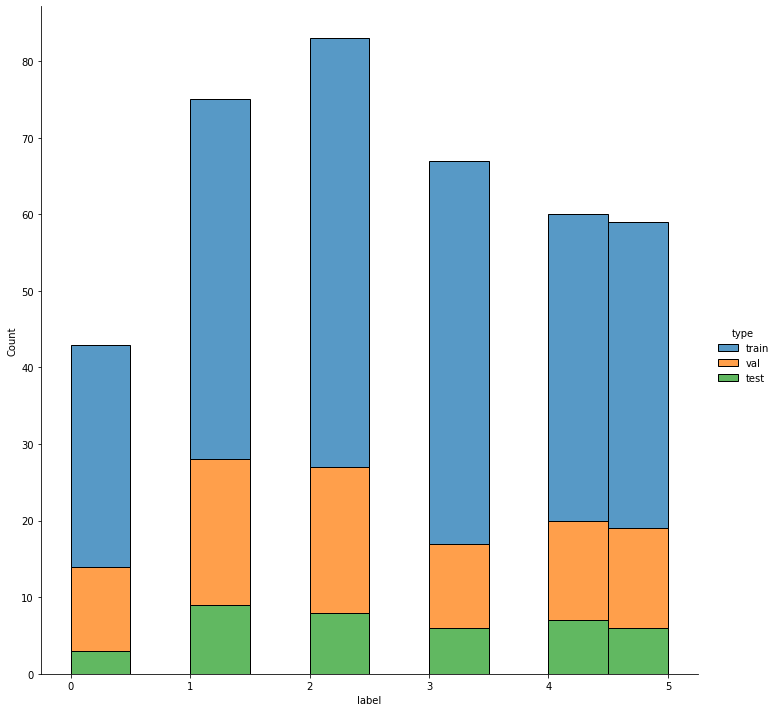

In [16]:
plot = sns.displot(data=df, x='label', kind='hist', hue='type', multiple="stack", height=10, aspect=1)
plot.savefig(f'{data_root}/labels_hist.jpg')

## Test Images

In [33]:
import random

In [32]:
df_val.head()

,image_path,label,type
0,imgs/Mouse/00033.jpg,4,val
1,imgs/Eraser/00010.jpg,0,val
2,imgs/Knives/00038.jpg,2,val
3,imgs/Knives/00062.jpg,2,val
4,imgs/Keyboard/00054.jpg,1,val


In [29]:
df_val_by_label = df_val.groupby(by='label')

In [35]:
for key, df in df_val_by_label:
    print(key)
    df['image_path']
    print(random.sample(df['image_path'], 3))
    break

0


TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [23]:
random.sample([1,2,3,4], 8)

ValueError: Sample larger than population or is negative